In [ ]:
"""installs"""

# !pip install nc-time-axis
# !pip install netCDF4 h5netcdf
# !pip install xarray
# !pip install cdsapi
# !pip install networkx geopandas osmnx igraph matplotlib
# !pip install pysal scikit-learn libpysal tobler geopandas numpy pandas networkx
# !pip install access
# !pip install transliterate


'installs'

In [ ]:
# !pip install hypernetx


In [ ]:
import sys
from pathlib import Path

# Add parent directory to Python path to enable imports from scripts/
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)


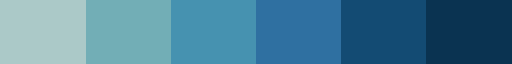

In [4]:
import scicolor

scicolor.get_cmap("Hokusai2")


In [ ]:
"""
проверить какой провижен новый или нет я юзаю
"""


'\nпроверить какой провижен новый или нет я юзаю\n'

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, MultiPolygon
import requests
from shapely.geometry import Point
import json
from collections import Counter

from transliterate import translit
import scripts_old.model as model
import scripts_old.provision as provision
import seaborn as sns
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import os
from tqdm import tqdm

tqdm.pandas()

from constants import *


In [ ]:
def fix_missing_capacity(row):
    """this is just a very straight forward workaround"""
    if row["population"] > 10e3 and row[f"capacity_{SERVICE_NAME}"] == 0:
        row[f"capacity_{SERVICE_NAME}"] = row["population"] / 2

    return int(row[f"capacity_{SERVICE_NAME}"])


def make_block_scheme(settl, df_service):
    blocks_gdf = model.create_blocks(
        settl, const_demand=CONST_BASE_DEMAND, epsg=MERCATOR_CRS
    )
    blocks_gdf = model.update_blocks_with_services(
        blocks_gdf, df_service, service_type=SERVICE_NAME
    )
    # Добавим колонку с транслитерированными именами
    blocks_gdf["name"] = blocks_gdf["name"].apply(
        lambda x: translit(x, "ru", reversed=True)
    )

    blocks_gdf[f"capacity_{SERVICE_NAME}"] = blocks_gdf.apply(
        fix_missing_capacity, axis=1
    )
    blocks_gdf = blocks_gdf.to_crs(MERCATOR_CRS)
    return blocks_gdf


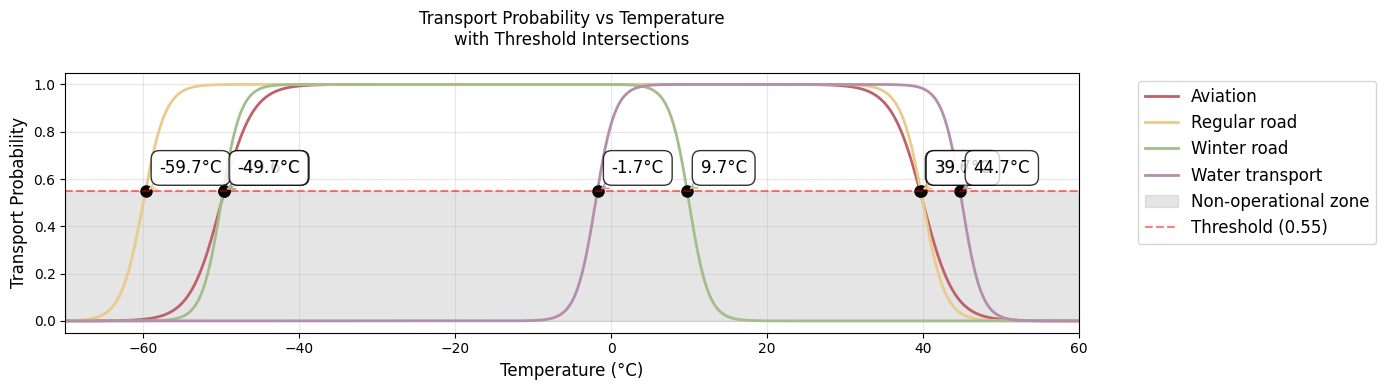

In [8]:
from plotter_transport_mode_prob import plot_transport_probability_legacy
from calculator_transport_prob import get_transport_probability

threshold_temperatures = plot_transport_probability_legacy(
    transport_modes,
    transport_modes_color,
    get_transport_probability,
    threshold,
    temps=None,
    font_size=12,
)


In [ ]:
"""
Добавить параллельно две карты:
- Распределение сервисов каждой группы (вместе? как кружками?) по нп
"""


'\nДобавить параллельно две карты:\n- Распределение сервисов каждой группы (вместе? как кружками?) по нп\n'

In [10]:
from preprocesser import get_data
from gcreator import make_g, add_temp_to_g
from plotter_network_basic import plot_transport_graph
from huston import call_nasa
from calculator_stat import create_agglomeration_network
from calculator_monthly_mode import create_df_modes_monthly_fixed
from plotter_heatmap import create_transport_mode_heatmaps
from plotter_heatmap_prov_node import plot_provision_evolution_by_node

# Store results for each settlement and service
all_results = {}
# yakut_chuk
# yanao_kras
# mezen

for SETTL_NAME in ["yanao_kras"]:
    print("=" * 10, SETTL_NAME, "=" * 10)

    # Initialize settlement results
    all_results[SETTL_NAME] = {}
    # service_list
    for SERVICE_NAME in service_list:
        print("||" * 10, SERVICE_NAME, "||" * 10)

        CLIMATE_DATA_FILE_NAME = f"df_climate_{SETTL_NAME}.csv"

        settl, df_service, transport_df, infr_df = get_data(
            data_path,
            SETTL_NAME,
            transport_mode_name_mapper,
            transport_modes,
            SERVICE_NAME,
        )
        blocks_gdf = make_block_scheme(settl, df_service)
        G_undirected = make_g(transport_df, transport_modes, blocks_gdf, settl)

        df_monthly_list = call_nasa(blocks_gdf, CLIMATE_DATA_FILE_NAME)
        G_undirected = add_temp_to_g(G_undirected, df_monthly_list)

        range_months = range(12)  # Starting 1982

        net = create_agglomeration_network(
            graph=G_undirected,
            threshold=threshold,
            probability_function=get_transport_probability,
            provision_calculator=provision.calculate_graph_provision,
        )

        net.run_all_steps(
            range_months,
            service_radius_minutes=SERVICE_RADIUS_MINUTES,
            base_demand=CONST_BASE_DEMAND,
            service_name=SERVICE_NAME,
            return_assignment=True,
        )

        # Store results for this service
        all_results[SETTL_NAME][SERVICE_NAME] = {
            "net": net,
            "stats": net.stats,
            "graphs": net.stats.graphs,
            "records": net.stats.records,
            "results": net.stats.results,
            "G_undirected": G_undirected,
        }

        # Предполагаем что индекс df_stats — это месяцы в виде `i` (0...len-1)
        df_stats = net.stats.records
        try:
            df_stats["Month"] = df_stats.index % MONTHS_IN_YEAR + 1
            df_stats["Year"] = START_YEAR + df_stats.index // MONTHS_IN_YEAR
        except Exception:
            pass

        df_modes_monthly = create_df_modes_monthly_fixed(
            G_undirected,
            transport_modes,
            threshold_temperatures,
            START_YEAR,
            MONTHS_IN_YEAR=12,
        )

        # Store df_modes_monthly as well
        all_results[SETTL_NAME][SERVICE_NAME]["df_modes_monthly"] = df_modes_monthly

    # # Plot results for each service in this settlement
    # for SERVICE_NAME in ["port"]:
    #     net = all_results[SETTL_NAME][SERVICE_NAME]["net"]
    #     G_undirected = all_results[SETTL_NAME][SERVICE_NAME]["G_undirected"]
    #     df_modes_monthly = all_results[SETTL_NAME][SERVICE_NAME]["df_modes_monthly"]

    #     plot_provision_evolution_by_node(net.stats.results, START_YEAR)
    #     plot_transport_graph(
    #         G_undirected,
    #         figsize=(15, 10),
    #         title=f"Transport Graph - {SETTL_NAME} - {SERVICE_NAME}",
    #     )
    #     create_transport_mode_heatmaps(
    #         df_modes_monthly=df_modes_monthly,
    #         transport_modes=transport_modes,
    #         month_order=month_order,
    #         max_nodes=len(G_undirected.nodes),
    #     )

# Now you can access any results like:
# all_results["yakut_chuk"]["health"]["graphs"]
# all_results["yakut_chuk"]["school"]["net"].stats.records


========== yanao_kras ==========
|||||||||||||||||||| school ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  6.56it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}
|||||||||||||||||||| kindergarten ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00, 10.21it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}
|||||||||||||||||||| post ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  9.27it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}
|||||||||||||||||||| library ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  8.93it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}
|||||||||||||||||||| culture ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  8.94it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}
|||||||||||||||||||| atm ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00, 10.27it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}
|||||||||||||||||||| health ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}
|||||||||||||||||||| port ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}
|||||||||||||||||||| airport ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00, 10.23it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}
|||||||||||||||||||| shop ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00, 10.63it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}
|||||||||||||||||||| pristan ||||||||||||||||||||


Running network analysis: 100%|██████████| 12/12 [00:01<00:00, 10.51it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}


In [ ]:
# import xgi
# import networkx as nx
# import numpy as np
# from tqdm import tqdm

# # Fix random seed
# # np.random.seed(42)

# nx_graphs = list()
# # Get the NetworkX graph from your data
# for service in tqdm(service_list):
#     nx_graphs.append(all_results["yanao_kras"][service]["graphs"][0])

# # Create hypergraph
# H = xgi.Hypergraph()

# # Add nodes with attributes from first graph
# for node, attrs in tqdm(nx_graphs[0].nodes(data=True)):
#     H.add_node(node, **attrs)

# # Add edges from each service with service type as attribute
# for service_idx, (service, nx_graph) in enumerate(tqdm(zip(service_list, nx_graphs))):
#     for edge_data in nx_graph.edges(data=True):
#         edge_nodes = edge_data[:2]  # First two elements are the nodes
#         attrs = edge_data[2]  # Third element is the attributes dict
#         edge_attrs = dict(attrs)
#         edge_attrs["service_type"] = service  # Add service type to edge attributes
#         edge_attrs["service_idx"] = service_idx  # Add numeric index for coloring
#         H.add_edge(edge_nodes, **edge_attrs)

# # Debug: Check what we have
# print(f"Number of nodes: {H.num_nodes}")
# print(f"Number of edges: {H.num_edges}")
# print(f"Nodes: {list(H.nodes)[:5]}...")  # Show first 5 nodes
# if H.num_edges > 0:
#     print(f"Edges: {list(H.edges)[:5]}...")  # Show first 5 edges

# # Only proceed if we have edges
# if H.num_edges > 0:
#     # Debug: Check edge structure
#     print(f"Total edges in hypergraph: {H.num_edges}")

#     # Get all dyads (2-node edges) specifically
#     dyads = [edge for edge in H.edges if len(H.edges.members(edge)) == 2]
#     print(f"Number of dyads (2-node edges): {len(dyads)}")

#     # Get service indices for dyad coloring only
#     dyad_colors = [H.edges[edge]["service_idx"] for edge in dyads]

#     # Visualize with edge colors differentiated by service type
#     pos = xgi.barycenter_spring_layout(H, seed=1)
#     xgi.draw(
#         H,
#         pos=pos,
#         dyad_color=dyad_colors,  # Color only the dyads
#         dyad_color_cmap="tab10",  # Distinct colors for each service
#         node_fc="lightgray",
#         node_ec="black",
#     )
# else:
#     print("No edges found! Check your NetworkX graphs.")
#     # Just draw nodes
#     pos = xgi.barycenter_spring_layout(H, seed=1)
#     xgi.draw(H, pos=pos, node_fc="lightgray", node_ec="black")


In [ ]:
# !pip install multiplex-plot


In [ ]:
# !pip install xgi


In [14]:
%load_ext autoreload
%autoreload 2


Using services: ['school', 'kindergarten', 'post', 'library', 'culture', 'atm', 'health', 'port', 'airport', 'shop', 'pristan']


/var/folders/jn/d6x3c7jd7594dtldxq22ysn80000gn/T/ipykernel_1384/1270785942.py:175: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(


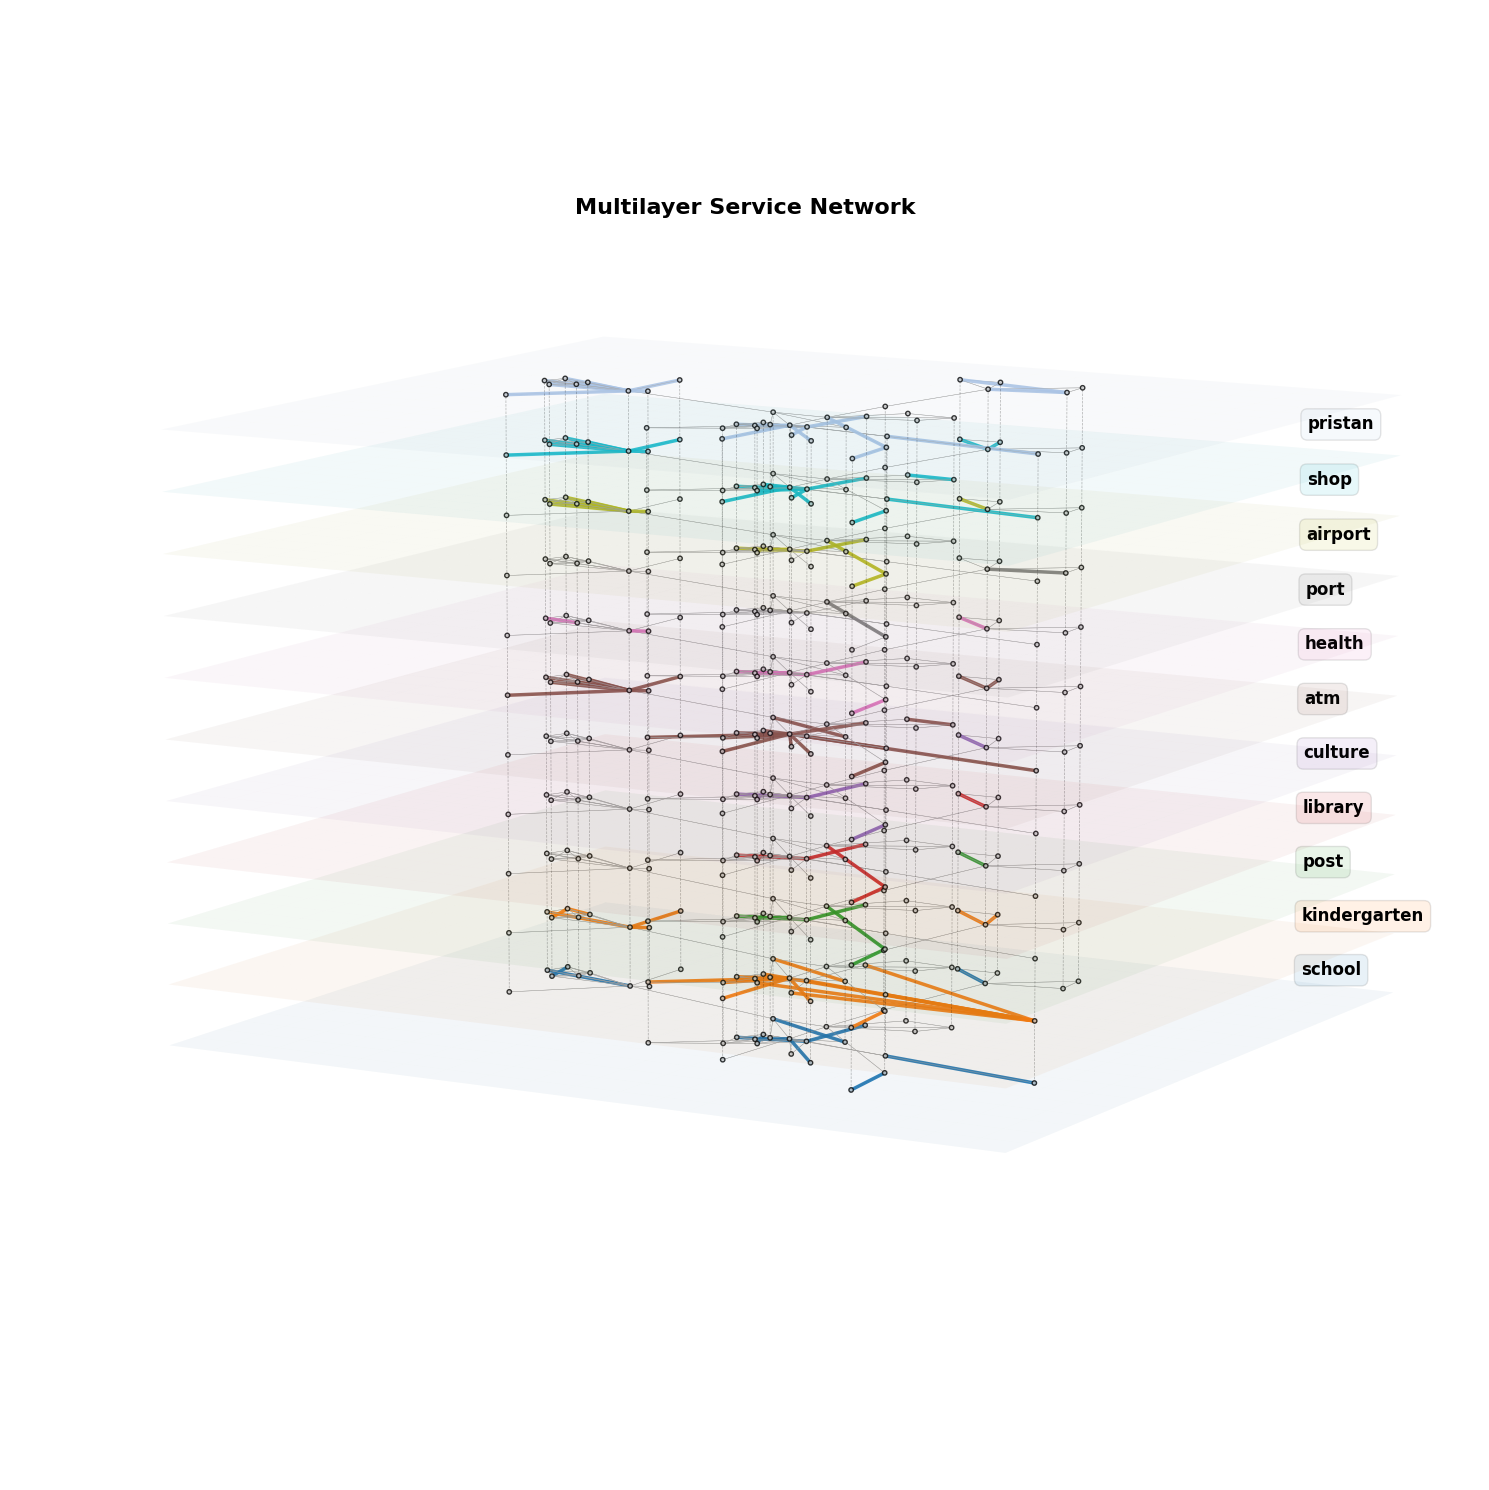

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# M = 5

for M in [5]:
    # Use first 5 services for clean visualization
    selected_services = service_list[:]
    print(f"Using services: {selected_services}")

    # Create the clean 3D multilayer plot (like XGI but without hyperedges)
    fig = plt.figure(figsize=(15, 30))
    ax = fig.add_subplot(111, projection="3d")

    # Define layer properties
    layer_colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
        "#aec7e8",
    ]
    layer_height = 2.0  # Separation between layers
    layer_alpha = 0.05  # Transparency for layer planes

    # Get common layout for all nodes
    all_nodes = set()
    for service in selected_services:
        nx_graph = all_results[SETTL_NAME][service]["graphs"][M]
        all_nodes.update(nx_graph.nodes())

    # Create master layout using first service graph
    master_graph = nx.Graph()
    master_graph.add_nodes_from(all_nodes)

    # Use the first service to get a good layout
    first_service_graph = all_results[SETTL_NAME][selected_services[0]]["graphs"][M]
    pos = nx.spring_layout(
        first_service_graph, seed=42, k=3, iterations=100
    )  # Better spacing

    # Scale positions for better 3D visualization
    for node in pos:
        pos[node] = (pos[node][0] * 6, pos[node][1] * 6)  # Slightly more spread

    # Store which nodes appear on which layers for inter-layer connections
    node_layers = {node: [] for node in all_nodes}

    # Draw each service layer
    for layer_idx, service in enumerate(selected_services):
        nx_graph = all_results[SETTL_NAME][service]["graphs"][M]
        z = layer_idx * layer_height
        color = layer_colors[layer_idx % len(layer_colors)]

        # Record which layer each node appears on
        for node in nx_graph.nodes():
            if node in all_nodes:
                node_layers[node].append(z)

        # Draw semi-transparent layer plane
        xx, yy = np.meshgrid(
            np.linspace(-8, 8, 20), np.linspace(-8, 8, 20)
        )  # Slightly larger
        zz = np.ones_like(xx) * z
        ax.plot_surface(
            xx,
            yy,
            zz,
            alpha=layer_alpha,
            color=color,
            linewidth=0,
            antialiased=True,
            shade=True,
        )

        # Draw nodes on this layer - color only if they have capacity > 0
        node_x, node_y, node_z = [], [], []
        node_colors = []
        node_sizes = []

        for node in nx_graph.nodes():
            if node in pos:
                x, y = pos[node]
                node_x.append(x)
                node_y.append(y)
                node_z.append(z)

                # Check if node has capacity for this service
                node_capacity = 0
                if node in all_results and service in all_results[node]:
                    node_data = all_results[node][service]
                    node_capacity = node_data.get(f"capacity_{service}", 0)

                # Color and size node based on capacity
                if node_capacity > 0:
                    node_colors.append(color)
                    node_sizes.append(200)  # Larger for providers
                else:
                    node_colors.append("lightgray")  # Gray for no capacity
                    node_sizes.append(10)  # Smaller for consumers

        # Plot nodes with conditional coloring and sizing
        ax.scatter(
            node_x,
            node_y,
            node_z,
            c=node_colors,
            s=node_sizes,
            alpha=0.8,
            edgecolors="black",
            linewidth=1.0,
            # depthshade=True,
        )

        # Draw edges - color by assignment if > 0
        for edge in nx_graph.edges(data=True):
            node1, node2 = edge[0], edge[1]
            edge_data = edge[2] if len(edge) > 2 else {}

            if node1 in pos and node2 in pos:
                x1, y1 = pos[node1]
                x2, y2 = pos[node2]

                # Check assignment value
                assignment = edge_data.get("assignment", 0)

                # Color edge based on assignment
                if assignment > 0:
                    edge_color = color  # Service color for active assignments
                    edge_alpha = 0.9
                    edge_width = 2.5
                else:
                    edge_color = "darkgray"  # Gray for no assignment
                    edge_alpha = 0.9
                    edge_width = 0.3

                ax.plot(
                    [x1, x2],
                    [y1, y2],
                    [z, z],
                    color=edge_color,
                    linewidth=edge_width,
                    alpha=edge_alpha,
                )

        # Add layer label with background
        ax.text(
            -20,
            1,
            z - 4.5,
            service,
            fontsize=12,
            weight="bold",
            bbox=dict(
                boxstyle="round,pad=0.4",
                facecolor=color,
                alpha=0.1,
                edgecolor="black",
                linewidth=1,
            ),
        )

    # Draw inter-layer connections (vertical lines between same nodes) - make more visible
    for node, layers in node_layers.items():
        if len(layers) > 1 and node in pos:  # Node appears on multiple layers
            x, y = pos[node]
            ax.plot(
                [x] * len(layers),
                [y] * len(layers),
                layers,
                "k--",
                linewidth=0.50,
                alpha=0.3,
                linestyle="--",
            )  # Solid line, more visible

    # Style the plot exactly like XGI's multilayer output
    # ax.set_xlabel(, fontsize=14, labelpad=15)
    # ax.set_ylabel("Y", fontsize=14, labelpad=15)
    # ax.set_zlabel("Service Layers", fontsize=14, labelpad=15)

    # Set clean viewing angle
    ax.view_init(elev=10, azim=30)  # Slightly different angle for better view

    # Clean up the plot appearance - remove grid
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Make pane edges invisible
    ax.xaxis.pane.set_edgecolor("white")
    ax.yaxis.pane.set_edgecolor("white")
    ax.zaxis.pane.set_edgecolor("white")
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)

    # # Set axis limits for better view
    ax.set_xlim(-8, 10)  # Slightly wider
    ax.set_ylim(-8, 8)

    # Add title
    plt.title(
        "Multilayer Service Network",
        # "\nService Providers Highlighted",
        fontsize=16,
        weight="bold",
        y=0.93,
    )

    # plt.xticks([])
    # plt.yticks([])
    # ax.set_zticks([])
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.sankey import Sankey


# def create_service_sankey_plots(G, service_name="school", min_flow=1):
#     """
#     Create Sankey diagrams showing service dependencies

#     Parameters:
#     G: NetworkX graph with service flow data
#     service_name: specific service to analyze
#     min_flow: minimum flow to include in diagram
#     """

#     fig, axes = plt.subplots(2, 1, figsize=(16, 12))

#     # Extract service flow data
#     service_flows = []
#     for source, target, data in G.edges(data=True):
#         if data.get("is_service_flow", False) and data.get("assignment", 0) >= min_flow:
#             assignment = data.get("assignment", 0)
#             if source != target:  # Exclude self-loops
#                 service_flows.append((source, target, assignment))

#     # Panel 1: Single service (school) Sankey
#     school_flows = []
#     for source, target, flow in service_flows:
#         # Check if target has school capacity
#         target_data = G.nodes[target]
#         if target_data.get("capacity_school", 0) > 0:
#             school_flows.append((source, target, flow))

#     if school_flows:
#         ax1 = axes[0]
#         sankey1 = Sankey(ax=ax1, scale=0.01, offset=0.3, format="%.0f", gap=0.7)

#         # Group flows by target (service provider)
#         provider_flows = {}
#         for source, target, flow in school_flows:
#             if target not in provider_flows:
#                 provider_flows[target] = []
#             provider_flows[target].append((source, flow))

#         # Create Sankey for each major provider
#         colors = plt.cm.Set3(np.linspace(0, 1, len(provider_flows)))

#         for i, (provider, flows) in enumerate(provider_flows.items()):
#             if len(flows) > 1:  # Only show providers with multiple consumers
#                 flows_in = [flow for _, flow in flows]
#                 flows_out = [-sum(flows_in)]  # Outgoing flow (negative)

#                 labels = [f"{source}" for source, _ in flows] + [
#                     f"{provider}\n(Provider)"
#                 ]

#                 sankey1.add(
#                     flows=flows_in + flows_out,
#                     labels=labels,
#                     orientations=[1] * len(flows_in) + [0],
#                     pathlengths=[0.25] * len(flows_in) + [0.25],
#                     trunklength=1.5,
#                     facecolor=colors[i],
#                     edgecolor=colors[i],
#                 )

#         diagrams = sankey1.finish()
#         for diagram in diagrams:
#             for text in diagram.texts:
#                 text.set_fontsize(8)

#         ax1.set_title(
#             f"{service_name.title()} Service Dependencies\n(Sankey Diagram)",
#             fontsize=14,
#         )
#         ax1.axis("off")

#     # Panel 2: All services Sankey (simplified)
#     if service_flows:
#         ax2 = axes[1]

#         # Aggregate flows by provider
#         provider_totals = {}
#         consumer_totals = {}

#         for source, target, flow in service_flows:
#             if target not in provider_totals:
#                 provider_totals[target] = 0
#             if source not in consumer_totals:
#                 consumer_totals[source] = 0
#             provider_totals[target] += flow
#             consumer_totals[source] += flow

#         # Get top providers and consumers
#         top_providers = sorted(
#             provider_totals.items(), key=lambda x: x[1], reverse=True
#         )[:5]
#         top_consumers = sorted(
#             consumer_totals.items(), key=lambda x: x[1], reverse=True
#         )[:5]

#         sankey2 = Sankey(ax=ax2, scale=0.01, offset=0.3, format="%.0f", gap=0.5)

#         # Create flows for top providers
#         flows = []
#         labels = []
#         orientations = []

#         for provider, total_flow in top_providers:
#             # Incoming flows to this provider
#             incoming = []
#             for source, target, flow in service_flows:
#                 if target == provider and source in [c[0] for c in top_consumers]:
#                     incoming.append(flow)
#                     if len(flows) == 0:  # Add consumer labels only once
#                         labels.append(f"{source}")
#                         orientations.append(1)

#             if incoming:
#                 flows.extend(incoming)
#                 flows.append(-sum(incoming))  # Outgoing flow
#                 labels.append(f"{provider}\n({total_flow})")
#                 orientations.append(0)

#         if flows:
#             sankey2.add(
#                 flows=flows,
#                 labels=labels,
#                 orientations=orientations,
#                 pathlengths=[0.25] * len(flows),
#                 trunklength=2.0,
#                 facecolor="lightblue",
#                 edgecolor="navy",
#             )

#             diagrams2 = sankey2.finish()
#             for diagram in diagrams2:
#                 for text in diagram.texts:
#                     text.set_fontsize(8)

#         ax2.set_title(
#             "All Services Dependencies\n(Top Providers & Consumers)", fontsize=14
#         )
#         ax2.axis("off")

#     plt.tight_layout()
#     plt.show()


# def create_advanced_sankey_with_plotly(G, min_flow=1):
#     """
#     Create interactive Sankey diagram using plotly (better for complex flows)
#     Requires: pip install plotly
#     """
#     try:
#         import plotly.graph_objects as go
#         from plotly.offline import plot

#         # Extract service flow data
#         service_flows = []
#         for source, target, data in G.edges(data=True):
#             if (
#                 data.get("is_service_flow", False)
#                 and data.get("assignment", 0) >= min_flow
#             ):
#                 assignment = data.get("assignment", 0)
#                 if source != target:
#                     service_flows.append((source, target, assignment))

#         if not service_flows:
#             print("No service flows found with minimum flow threshold")
#             return

#         # Create node lists
#         all_nodes = list(
#             set(
#                 [source for source, _, _ in service_flows]
#                 + [target for _, target, _ in service_flows]
#             )
#         )
#         node_dict = {node: i for i, node in enumerate(all_nodes)}

#         # Prepare data for Sankey
#         source_indices = [node_dict[source] for source, _, _ in service_flows]
#         target_indices = [node_dict[target] for _, target, _ in service_flows]
#         values = [flow for _, _, flow in service_flows]

#         # Create colors
#         colors = ["rgba(31, 119, 180, 0.8)"] * len(all_nodes)

#         # Create Sankey diagram
#         fig = go.Figure(
#             data=[
#                 go.Sankey(
#                     node=dict(
#                         pad=15,
#                         thickness=20,
#                         line=dict(color="black", width=0.5),
#                         label=all_nodes,
#                         color=colors,
#                     ),
#                     link=dict(
#                         source=source_indices, target=target_indices, value=values
#                     ),
#                 )
#             ]
#         )

#         fig.update_layout(
#             title_text="Service Dependencies Flow Diagram",
#             font_size=10,
#             width=1200,
#             height=800,
#         )

#         # Save as HTML file
#         plot(fig, filename="service_sankey.html", auto_open=True)
#         print("Interactive Sankey diagram saved as 'service_sankey.html'")

#     except ImportError:
#         print("Plotly not installed. Install with: pip install plotly")
#         print("Using matplotlib version instead...")
#         create_service_sankey_plots(G)


# def create_simple_sankey_matplotlib(G, min_flow=1):
#     """
#     Simplified Sankey using matplotlib for clearer visualization
#     """
#     import matplotlib.patches as patches

#     fig, ax = plt.subplots(figsize=(14, 7))

#     # Extract and process flow data
#     flows = []
#     for source, target, data in G.edges(data=True):
#         if data.get("is_service_flow", False) and data.get("assignment", 0) >= min_flow:
#             assignment = data.get("assignment", 0)
#             if source != target:
#                 flows.append((source, target, assignment))

#     if not flows:
#         print(f"No flows found with minimum threshold {min_flow}")
#         return

#     # Group by providers
#     providers = {}
#     for source, target, flow in flows:
#         if target not in providers:
#             providers[target] = []
#         providers[target].append((source, flow))

#     # Sort providers by total flow
#     provider_totals = {p: sum(f for _, f in flows) for p, flows in providers.items()}
#     sorted_providers = sorted(provider_totals.items(), key=lambda x: x[1], reverse=True)

#     # Draw simplified flow diagram
#     y_pos = 0.8
#     colors = plt.cm.Set3(np.linspace(0, 1, len(sorted_providers)))

#     for i, (provider, total_flow) in enumerate(sorted_providers[:6]):  # Top 6 providers
#         consumer_flows = providers[provider]
#         consumer_flows.sort(key=lambda x: x[1], reverse=True)

#         # Draw provider box
#         provider_height = 0.1
#         provider_rect = patches.Rectangle(
#             (0.7, y_pos),
#             0.25,
#             provider_height,
#             linewidth=1,
#             edgecolor="black",
#             facecolor=colors[i],
#             alpha=0.7,
#         )
#         ax.add_patch(provider_rect)
#         ax.text(
#             0.825,
#             y_pos + provider_height / 2,
#             f"{provider}\n{total_flow}",
#             ha="center",
#             va="center",
#             fontsize=9,
#             weight="bold",
#         )

#         # Draw consumer flows
#         consumer_y = y_pos
#         for j, (consumer, flow) in enumerate(
#             consumer_flows[:4]
#         ):  # Top 4 consumers per provider
#             # Consumer box
#             consumer_height = 0.02 + (flow / max(f for _, f in consumer_flows)) * 0.06
#             consumer_rect = patches.Rectangle(
#                 (0.05, consumer_y),
#                 0.2,
#                 consumer_height,
#                 linewidth=1,
#                 edgecolor="gray",
#                 facecolor="lightcoral",
#                 alpha=0.6,
#             )
#             ax.add_patch(consumer_rect)
#             ax.text(
#                 0.15,
#                 consumer_y + consumer_height / 2,
#                 f"{consumer}",
#                 ha="center",
#                 va="center",
#                 fontsize=7,
#             )

#             # Flow line
#             flow_width = (flow / max(f for _, f in consumer_flows)) * 0.02 + 0.002
#             ax.plot(
#                 [0.25, 0.7],
#                 [consumer_y + consumer_height / 2, y_pos + provider_height / 2],
#                 linewidth=flow_width * 1000,
#                 color=colors[i],
#                 alpha=0.6,
#             )

#             # Flow label
#             mid_x, mid_y = (
#                 0.475,
#                 (consumer_y + consumer_height / 2 + y_pos + provider_height / 2) / 2,
#             )
#             ax.text(
#                 mid_x,
#                 mid_y,
#                 str(flow),
#                 ha="center",
#                 va="center",
#                 fontsize=6,
#                 bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8),
#             )

#             consumer_y += consumer_height + 0.01

#         y_pos -= 0.15

#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
#     ax.set_title(
#         "Service Dependencies - Sankey Style\n(Flow Thickness = Population Size)",
#         fontsize=16,
#     )
#     ax.text(0.15, 0.95, "Service Consumers", ha="center", fontsize=12, weight="bold")
#     ax.text(0.825, 0.95, "Service Providers", ha="center", fontsize=12, weight="bold")
#     ax.axis("off")

#     plt.tight_layout()
#     plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import numpy as np


# def create_simple_sankey(graphs, min_flow=1, max_columns=5):
#     """
#     Create Sankey diagram showing how service assignments change over time
#     Shows: consumers → providers (time 1) → providers (time 2) → etc.

#     Parameters:
#     graphs: List of NetworkX graphs representing different time periods
#     min_flow: Minimum flow threshold to display
#     max_columns: Maximum number of time periods to show (default 5)
#     """
#     # Handle both single graph and list of graphs
#     if not isinstance(graphs, list):
#         graph_list = [graphs]
#     else:
#         graph_list = graphs

#     # Check if we have nested lists
#     if isinstance(graph_list[0], list):
#         flattened = []
#         for item in graph_list:
#             if isinstance(item, list):
#                 flattened.extend(item)
#             else:
#                 flattened.append(item)
#         graph_list = flattened

#     # Limit number of graphs to avoid overcrowding
#     if len(graph_list) > max_columns:
#         graph_list = graph_list[:max_columns]
#         print(f"Limiting display to first {max_columns} time periods")

#     # Adjust figure size based on number of columns
#     fig_width = max(12, 4 + 3 * len(graph_list))  # Minimum 12, then 3 units per column
#     fig_height = 10

#     fig, ax = plt.subplots(figsize=(fig_width, fig_height))

#     # Extract service assignments for each time period
#     all_assignments = []  # List of {consumer: provider, flow} for each time period

#     for graph_idx, G in enumerate(graph_list):
#         assignments = {}  # {consumer: (provider, flow)}

#         # Extract service flows (consumer -> provider assignments)
#         for source, target, data in G.edges(data=True):
#             if (
#                 data.get("is_service_flow", False)
#                 and data.get("assignment", 0) >= min_flow
#             ):
#                 assignment = data.get("assignment", 0)

#                 if source != target:
#                     assignments[source] = (target, assignment)

#         # Check for nodes with unmet demand (provision < 1) that have no service flows
#         for node_name, node_data in G.nodes(data=True):
#             provision = node_data.get("provision", 0)  # Default to 1.0 if not specified
#             demand_without = node_data.get("demand", 0) - node_data.get(
#                 "demand_within", 0
#             )

#             # If node has unmet demand (provision < 1) and no provider assignment
#             if provision < 1.0 and node_name not in assignments:
#                 # Use demand_without if available, otherwise estimate from provision
#                 if demand_without >= min_flow:
#                     assignments[node_name] = ("NO_PROVIDER", demand_without)
#                 else:
#                     continue

#         all_assignments.append(assignments)

#     if not all_assignments:
#         print("No assignments found")
#         return

#     # Create columns: consumers, providers_t1, providers_t2, etc.
#     all_columns = []
#     all_flows = []

#     # First column: consumers (from first time period)
#     # Include ALL nodes with population, even those with no service flows
#     consumers = {}
#     first_graph = all_assignments[0] if all_assignments else {}

#     # Start with nodes that have assignments
#     for consumer, (provider, flow) in first_graph.items():
#         consumers[consumer] = flow

#     # Add nodes that have no service flows but have population (completely unprovided)
#     if graph_list:
#         G_first = graph_list[0]
#         for node_name, node_data in G_first.nodes(data=True):
#             demand = node_data.get("demand", 0)
#             provision = node_data.get("provision", 1.0)

#             # If node has population but no assignment and low provision, add it
#             if demand > 0 and node_name not in consumers and provision < 1.0:
#                 # Use population as flow amount for completely unprovided nodes
#                 consumers[node_name] = demand
#                 # Also add to first assignments as NO_PROVIDER
#                 if all_assignments:
#                     all_assignments[0][node_name] = ("NO_PROVIDER", demand)

#     all_columns.append(consumers)

#     # Provider columns for each time period
#     for time_idx, assignments in enumerate(all_assignments):
#         providers = {}

#         # For first time period, use assignment flows directly
#         if time_idx == 0:
#             for consumer, (provider, flow) in assignments.items():
#                 if provider not in providers:
#                     providers[provider] = 0
#                 providers[provider] += flow
#         else:
#             # For subsequent periods, calculate incoming flows from transitions
#             prev_assignments = all_assignments[time_idx - 1]

#             # Calculate transitions and ensure flow conservation
#             for consumer in prev_assignments:
#                 prev_provider, prev_flow = prev_assignments[consumer]

#                 if consumer in assignments:
#                     # Consumer continues with assignment - preserve flow amount
#                     next_provider, next_flow = assignments[consumer]
#                     if next_provider not in providers:
#                         providers[next_provider] = 0
#                     providers[next_provider] += prev_flow  # Use PREVIOUS flow amount
#                 else:
#                     # Consumer lost service - all flow goes to NO_PROVIDER
#                     if "NO_PROVIDER" not in providers:
#                         providers["NO_PROVIDER"] = 0
#                     providers["NO_PROVIDER"] += prev_flow

#             # Handle new consumers that appear (should be rare and come from NO_PROVIDER reserves)
#             for consumer in assignments:
#                 if consumer not in prev_assignments:
#                     next_provider, next_flow = assignments[consumer]
#                     if next_provider not in providers:
#                         providers[next_provider] = 0
#                     # This flow should come from NO_PROVIDER reserves
#                     providers[next_provider] += next_flow

#         all_columns.append(providers)

#         # Create flows: consumer -> provider (for first time period)
#         if time_idx == 0:
#             # Include flows for all consumers, including those going to NO_PROVIDER
#             flows = [
#                 (consumer, provider, flow)
#                 for consumer, (provider, flow) in assignments.items()
#             ]
#             all_flows.append(flows)

#     # Create transition flows between time periods with strict flow conservation
#     for time_idx in range(len(all_assignments) - 1):
#         current_assignments = all_assignments[time_idx]
#         next_assignments = all_assignments[time_idx + 1]

#         # Track how each consumer's provider assignment changes
#         transition_flows = []

#         # Get all consumers that had assignments in current time period
#         for consumer in current_assignments:
#             current_provider, current_flow = current_assignments[consumer]

#             if consumer in next_assignments:
#                 # Consumer has assignment in next period - use SAME flow amount
#                 next_provider, next_flow = next_assignments[consumer]
#                 transition_flows.append((current_provider, next_provider, current_flow))
#             else:
#                 # Consumer lost service assignment - ALL flow goes to NO_PROVIDER
#                 transition_flows.append((current_provider, "NO_PROVIDER", current_flow))

#         # Check for consumers that appear in next period but not current
#         # These should come from NO_PROVIDER (not add new flow)
#         for consumer in next_assignments:
#             if consumer not in current_assignments:
#                 next_provider, next_flow = next_assignments[consumer]
#                 # This flow should come from NO_PROVIDER reserves
#                 transition_flows.append(("NO_PROVIDER", next_provider, next_flow))

#         all_flows.append(transition_flows)

#     # Calculate positions for all columns with better spacing
#     num_columns = len(all_columns)
#     column_width = min(
#         0.12, 0.8 / num_columns
#     )  # Adapt column width to number of columns

#     # Better column spacing calculation
#     if num_columns <= 3:
#         column_spacing = 0.25
#         start_x = 0.1
#     elif num_columns <= 5:
#         column_spacing = 0.18
#         start_x = 0.08
#     else:
#         column_spacing = 0.15
#         start_x = 0.05

#     column_positions = []
#     for col_idx in range(num_columns):
#         x_pos = start_x + col_idx * column_spacing
#         column_positions.append(x_pos)

#     # Draw all columns
#     node_positions = {}

#     for col_idx, column_data in enumerate(all_columns):
#         if not column_data:
#             continue

#         # Sort nodes by flow size
#         sorted_nodes = sorted(column_data.items(), key=lambda x: x[1], reverse=True)

#         # Calculate total column height needed
#         total_flow = sum(column_data.values())
#         available_height = 0.8

#         current_y = 0.9
#         x_pos = column_positions[col_idx]

#         for node, flow in sorted_nodes:
#             # Calculate box height proportional to flow
#             height = (flow / total_flow) * available_height if total_flow > 0 else 0.05
#             height = max(height, 0.02)  # Minimum height

#             y_pos = current_y - height / 2

#             # Store position
#             node_positions[(col_idx, node)] = {
#                 "x": x_pos,
#                 "y": y_pos,
#                 "width": column_width,
#                 "height": height,
#                 "flow": flow,
#             }

#             # Draw box
#             if node == "NO_PROVIDER":
#                 color = "darkred"
#                 edge_color = "black"
#                 label = f"NO PROVIDER\n({flow})"
#             elif node == "UNMET":
#                 color = "red"
#                 edge_color = "darkred"
#                 label = f"UNMET\n({flow})"
#             elif col_idx == 0:  # First column = consumers
#                 color = "lightcoral"
#                 edge_color = "darkred"
#                 label = f"{node}\n({flow})"
#             else:  # Provider columns
#                 color = "lightblue"
#                 edge_color = "darkblue"
#                 label = f"{node}\n({flow})"

#             rect = patches.Rectangle(
#                 (x_pos, y_pos),
#                 column_width,
#                 height,
#                 facecolor=color,
#                 edgecolor=edge_color,
#                 linewidth=1,
#                 alpha=0.8,
#             )
#             ax.add_patch(rect)

#             # Add label with adaptive font size
#             font_size = max(
#                 6, min(8, 100 / num_columns)
#             )  # Smaller font for more columns
#             ax.text(
#                 x_pos + column_width / 2,
#                 y_pos + height / 2,
#                 label,
#                 ha="center",
#                 va="center",
#                 fontsize=font_size,
#                 weight="bold",
#             )

#             current_y -= height + 0.01  # Small gap between boxes

#     # Draw flows between adjacent columns
#     for flow_idx, flows in enumerate(all_flows):
#         source_col = flow_idx
#         target_col = flow_idx + 1

#         if source_col >= len(all_columns) or target_col >= len(all_columns):
#             continue

#         # Get flow thickness scaling
#         max_flow = max(flow for _, _, flow in flows) if flows else 1

#         # Group flows by source-target pairs and sum them
#         flow_dict = {}
#         for source, target, flow in flows:
#             key = (source, target)
#             if key not in flow_dict:
#                 flow_dict[key] = 0
#             flow_dict[key] += flow

#         for (source, target), total_flow in flow_dict.items():
#             # Find source and target positions
#             source_key = (source_col, source)
#             target_key = (target_col, target)

#             if source_key not in node_positions or target_key not in node_positions:
#                 continue

#             source_pos = node_positions[source_key]
#             target_pos = node_positions[target_key]

#             # Calculate connection points
#             source_right = source_pos["x"] + source_pos["width"]
#             source_y = source_pos["y"] + source_pos["height"] / 2

#             target_left = target_pos["x"]
#             target_y = target_pos["y"] + target_pos["height"] / 2

#             # Flow thickness
#             thickness = (total_flow / max_flow) * 8 + 1

#             # Color based on flow type
#             if target == "NO_PROVIDER":
#                 color = "darkred"
#             elif target == "UNMET":
#                 color = "red"
#             elif flow_idx == 0:  # Consumer to first provider
#                 color = "gray"
#             else:  # Provider to provider transitions
#                 color = "blue"

#             # Draw flow line
#             ax.plot(
#                 [source_right, target_left],
#                 [source_y, target_y],
#                 linewidth=thickness,
#                 color=color,
#                 alpha=0.6,
#             )

#             # Flow label with adaptive size
#             mid_x = (source_right + target_left) / 2
#             mid_y = (source_y + target_y) / 2
#             label_font_size = max(5, min(7, 80 / num_columns))
#             ax.text(
#                 mid_x,
#                 mid_y,
#                 str(total_flow),
#                 ha="center",
#                 va="center",
#                 fontsize=label_font_size,
#                 bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0.8),
#             )

#     # Add column headers with adaptive font size
#     header_font_size = max(8, min(12, 120 / num_columns))
#     column_labels = ["CONSUMERS"] + [
#         f"T{i}" if num_columns > 4 else f"TIME {i}" for i in range(1, num_columns)
#     ]

#     for col_idx, label in enumerate(column_labels):
#         if col_idx < len(column_positions):
#             x_pos = column_positions[col_idx]
#             ax.text(
#                 x_pos + column_width / 2,
#                 0.95,
#                 label,
#                 ha="center",
#                 va="center",
#                 fontsize=header_font_size,
#                 weight="bold",
#                 bbox=dict(boxstyle="round,pad=0.2", facecolor="lightyellow", alpha=0.7),
#             )

#     # Set limits and styling
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)

#     # Add demand accounting summary at the bottom
#     # demand_text_lines = []
#     # for summary in demand_summary:
#     #     demand_text_lines.append(f"{summary['period']}: within={summary['total_demand_within']}, "
#     #                            f"total={summary['total_demand_total']}, unprov={summary['total_unprov_demand']}")

#     # demand_text = " | ".join(demand_text_lines)
#     # ax.text(0.5, 0.02, f"Demand Accounting:\n{demand_text}",
#     #        ha='center', va='bottom', fontsize=9, weight='bold',
#     #        bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))

#     # Add flow conservation summary above demand accounting
#     flow_summary = []
#     for col_idx, column_data in enumerate(all_columns):
#         total_flow = sum(column_data.values())
#         if col_idx == 0:
#             flow_summary.append(f"Consumers: {total_flow}")
#         else:
#             flow_summary.append(f"T{col_idx}: {total_flow}")

#     summary_text = " → ".join(flow_summary)
#     ax.text(
#         0.5,
#         0.08,
#         f"Flow Conservation: {summary_text}",
#         ha="center",
#         va="bottom",
#         fontsize=10,
#         weight="bold",
#         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7),
#     )

#     ax.set_title(
#         f"Service Assignment Changes Over Time\n(Minimum flow: {min_flow})",
#         fontsize=16,
#         pad=20,
#     )
#     ax.axis("off")

#     plt.tight_layout()
#     plt.show()


In [ ]:
# # Usage example:
# graphs = all_results["yakut_chuk"]["port"]["stats"].graphs[5:11]


In [ ]:
import plotly.graph_objects as go
import pandas as pd


def create_clean_sankey(
    graphs,
    month_start,
    service_name,
    min_flow=1,
):
    """
    Create clean Sankey: Consumers -> T1_Providers -> T2_Providers -> T3_Providers
    Simple and straightforward approach
    """

    print(f"Creating Sankey for {len(graphs)} time periods...")

    # Step 1: Get all unique consumers (from first graph), excluding self-sufficient ones
    G1 = graphs[0]
    consumers = {}  # {consumer_name: total_demand}

    # Find settlements with self-loops and full provision
    self_sufficient = set()
    for source, target, data in G1.edges(data=True):
        if data.get("is_service_flow", False) and source == target:  # Self-loop
            # Check if this settlement has full provision
            node_data = G1.nodes[source]
            provision = node_data.get("provision", 0)
            if provision >= 1.0:  # Fully provided
                self_sufficient.add(source)

    print(
        f"Excluding {len(self_sufficient)} self-sufficient settlements: {list(self_sufficient)}"
    )

    # Add consumers excluding self-sufficient ones
    for node_name, node_data in G1.nodes(data=True):
        demand = node_data.get("demand", 0)
        if demand > 0 and node_name not in self_sufficient:
            consumers[node_name] = demand

    print(f"Found {len(consumers)} consumers")

    # Step 2: Get provider assignments for each time period
    all_assignments = []  # [{consumer: provider}, {consumer: provider}, ...]

    for t, G in enumerate(graphs):
        assignments = {}

        # Get service flows (exclude self-service completely)
        for source, target, data in G.edges(data=True):
            if (
                data.get("is_service_flow", False)
                and data.get("assignment", 0) >= min_flow
                and source != target
            ):  # Only external service flows
                if source in consumers:  # Only consumers we know about
                    assignments[source] = target

        # For consumers with NO external assignments, they go to NO_PROVIDER
        # (This excludes self-sufficient settlements completely)
        for consumer in consumers:
            if consumer not in assignments:
                assignments[consumer] = "NO_PROVIDER"

        all_assignments.append(assignments)
        print(
            f"T{t+1}: {len([p for p in assignments.values() if p != 'NO_PROVIDER'])} assignments, "
            f"{len([p for p in assignments.values() if p == 'NO_PROVIDER'])} no provider"
        )

    # Step 3: Create Sankey nodes
    sankey_nodes = []
    node_indices = {}

    # Add consumers (sorted by demand)
    sorted_consumers = sorted(consumers.items(), key=lambda x: x[1], reverse=True)
    for consumer, demand in sorted_consumers:
        sankey_nodes.append(consumer)
        node_indices[consumer] = len(sankey_nodes) - 1

    # Add providers for each time period (sorted by total flow they receive)
    for t in range(len(graphs)):
        # Calculate total flow to each provider
        provider_flows = {}
        for consumer, provider in all_assignments[t].items():
            consumer_demand = consumers[consumer]
            if provider not in provider_flows:
                provider_flows[provider] = 0
            provider_flows[provider] += consumer_demand

        # Sort providers by flow
        sorted_providers = sorted(
            provider_flows.items(), key=lambda x: x[1], reverse=True
        )

        for provider, flow in sorted_providers:
            provider_label = f"{provider}_T{t+1}"
            sankey_nodes.append(provider_label)
            node_indices[provider_label] = len(sankey_nodes) - 1

    print(f"Created {len(sankey_nodes)} nodes")

    # Step 4: Create Sankey flows
    sankey_sources = []
    sankey_targets = []
    sankey_values = []

    # Flows from consumers to T1 providers
    for consumer, provider in all_assignments[0].items():
        consumer_demand = consumers[consumer]
        provider_label = f"{provider}_T1"

        source_idx = node_indices[consumer]
        target_idx = node_indices[provider_label]

        sankey_sources.append(source_idx)
        sankey_targets.append(target_idx)
        sankey_values.append(consumer_demand)

    # Flows between time periods (T1 -> T2, T2 -> T3, etc.)
    for t in range(len(all_assignments) - 1):
        current_assignments = all_assignments[t]
        next_assignments = all_assignments[t + 1]

        for consumer in consumers:
            consumer_demand = consumers[consumer]

            current_provider = current_assignments[consumer]
            next_provider = next_assignments[consumer]

            current_label = f"{current_provider}_T{t+1}"
            next_label = f"{next_provider}_T{t+2}"

            source_idx = node_indices[current_label]
            target_idx = node_indices[next_label]

            sankey_sources.append(source_idx)
            sankey_targets.append(target_idx)
            sankey_values.append(consumer_demand)

    print(f"Created {len(sankey_sources)} flows")

    # Step 6: Create colors
    node_colors = []
    for node in sankey_nodes:
        if node in consumers:  # Consumer
            node_colors.append("#1E88E5")  # Blue instead of red
        elif "NO_PROVIDER" in node:  # No provider
            node_colors.append("#FF4757")  # Dark red
        else:  # Provider
            node_colors.append("#26C6DA")  # Light teal

    # Create flow colors
    flow_colors = []
    for i in range(len(sankey_sources)):
        target_node = sankey_nodes[sankey_targets[i]]
        if "NO_PROVIDER" in target_node:
            flow_colors.append("rgba(255, 71, 87, 0.7)")  # Red for NO_PROVIDER
        else:
            flow_colors.append("rgba(149, 165, 166, 0.5)")  # Gray for normal flows

    # Step 7: Create Plotly figure with simpler positioning
    fig = go.Figure(
        data=[
            go.Sankey(
                node=dict(
                    pad=15,
                    thickness=20,
                    line=dict(color="black", width=0.8),
                    label=sankey_nodes,
                    color=node_colors,
                    # Remove x,y positioning to let Plotly handle it naturally
                ),
                link=dict(
                    source=sankey_sources,
                    target=sankey_targets,
                    value=sankey_values,
                    color=flow_colors,
                ),
            )
        ]
    )

    # Determine number of time periods for dynamic headers
    num_periods = len(graphs)

    # Create column headers based on number of periods
    annotations = [
        dict(
            x=0.00,
            y=1.05,
            text="<b>Consumers</b>",
            showarrow=False,
            xref="paper",
            yref="paper",
            font=dict(size=14),
        ),
    ]

    # Add provider column headers dynamically
    for t in range(num_periods):
        x_pos = 0.16 + ((t) / (num_periods))  # Spread provider columns evenly
        annotations.append(
            dict(
                x=x_pos,
                y=1.05,
                text=f"<b>{month_order[month_start+t]}</b>",
                showarrow=False,
                xref="paper",
                yref="paper",
                font=dict(size=14),
            )
        )

    fig.update_layout(
        title_text=f"{service_name.title()} Service Flow Redistribution",
        font_size=11,
        width=1400,
        height=700,
        annotations=annotations,
    )

    fig.show()
    return fig


# Usage:
# Usage example:
for service in service_list:
    try:
        month_start = 8
        end_month = 9
        graphs = all_results[SETTL_NAME][service]["stats"].graphs[month_start:end_month]
        fig = create_clean_sankey(graphs, service_name=service, month_start=month_start)
    except Exception as ex:
        print(ex)


Creating Sankey for 1 time periods...
Excluding 27 self-sufficient settlements: ['Tazovskij', 'Antipajuta', 'Potapovo', 'Kresty', 'Katyryk', 'Nosok', 'Syndassko', 'Hatanga', 'Volochanka', 'Hantajskoe Ozero', 'Tarko-Sale', 'Gyda', 'Dikson', 'Nahodka', 'Karaul', 'Heta', 'Popigaj', "Noril'sk", 'Novyj Urengoj', 'Novorybnaja', "Tol'ka", 'Dudinka', 'Gaz-Sale', "Ust'-Port", "Krasnosel'kup", 'Ratta', 'Vorontsovo']
Found 11 consumers
T1: 11 assignments, 0 no provider
Created 20 nodes
Created 11 flows


Creating Sankey for 1 time periods...
Excluding 17 self-sufficient settlements: ["Tol'ka", 'Dudinka', 'Tazovskij', 'Hatanga', 'Antipajuta', 'Gaz-Sale', 'Tarko-Sale', "Noril'sk", 'Kresty', 'Katyryk', 'Gyda', "Krasnosel'kup", 'Nahodka', 'Dikson', 'Vorontsovo', 'Novyj Urengoj', 'Novorybnaja']
Found 21 consumers
T1: 21 assignments, 0 no provider
Created 28 nodes
Created 21 flows


Creating Sankey for 1 time periods...
Excluding 32 self-sufficient settlements: ['Ratta', 'Tazovskij', 'Antipajuta', 'Potapovo', 'Kresty', 'Katyryk', 'Novaja', 'Nosok', 'Syndassko', 'Hatanga', 'Volochanka', 'Hantajskoe Ozero', 'Tarko-Sale', 'Tuhard', 'Gyda', 'Dikson', 'Nahodka', 'Karaul', 'Heta', 'Popigaj', "Noril'sk", 'Zhdaniha', 'Novyj Urengoj', 'Novorybnaja', "Tol'ka", 'Dudinka', "Ust'-Avam", 'Gaz-Sale', "Ust'-Port", "Krasnosel'kup", 'Bajkalovsk', 'Vorontsovo']
Found 6 consumers
T1: 6 assignments, 0 no provider
Created 11 nodes
Created 6 flows


Creating Sankey for 1 time periods...
Excluding 33 self-sufficient settlements: ['Ratta', 'Tazovskij', 'Antipajuta', 'Potapovo', 'Kresty', 'Katyryk', 'Novaja', 'Nosok', 'Syndassko', 'Hatanga', 'Volochanka', 'Hantajskoe Ozero', 'Tarko-Sale', 'Tuhard', 'Gyda', 'Dikson', 'Nahodka', 'Karaul', 'Heta', 'Popigaj', "Noril'sk", 'Zhdaniha', 'Novyj Urengoj', 'Novorybnaja', "Tol'ka", 'Dudinka', "Ust'-Avam", 'Gaz-Sale', "Ust'-Port", "Krasnosel'kup", 'Bajkalovsk', 'Levinskie Peski', 'Vorontsovo']
Found 5 consumers
T1: 5 assignments, 0 no provider
Created 9 nodes
Created 5 flows


Creating Sankey for 1 time periods...
Excluding 33 self-sufficient settlements: ['Ratta', 'Tazovskij', 'Antipajuta', 'Potapovo', 'Kresty', 'Katyryk', 'Novaja', 'Nosok', 'Syndassko', 'Hatanga', 'Volochanka', 'Hantajskoe Ozero', 'Tarko-Sale', 'Tuhard', 'Gyda', 'Dikson', 'Nahodka', 'Karaul', 'Heta', 'Popigaj', "Noril'sk", 'Zhdaniha', 'Novyj Urengoj', 'Novorybnaja', "Tol'ka", 'Dudinka', "Ust'-Avam", 'Gaz-Sale', "Ust'-Port", "Krasnosel'kup", 'Bajkalovsk', 'Levinskie Peski', 'Vorontsovo']
Found 5 consumers
T1: 5 assignments, 0 no provider
Created 9 nodes
Created 5 flows


Creating Sankey for 1 time periods...
Excluding 12 self-sufficient settlements: ["Tol'ka", 'Dudinka', 'Tazovskij', 'Hatanga', 'Antipajuta', 'Gaz-Sale', 'Tarko-Sale', "Noril'sk", 'Gyda', "Krasnosel'kup", 'Dikson', 'Novyj Urengoj']
Found 26 consumers
T1: 26 assignments, 0 no provider
Created 32 nodes
Created 26 flows


Creating Sankey for 1 time periods...
Excluding 30 self-sufficient settlements: ['Ratta', 'Tazovskij', 'Antipajuta', 'Potapovo', 'Kresty', 'Katyryk', 'Novaja', 'Nosok', 'Hatanga', 'Volochanka', 'Hantajskoe Ozero', 'Tarko-Sale', 'Tuhard', 'Gyda', 'Dikson', 'Nahodka', 'Karaul', 'Heta', 'Popigaj', "Noril'sk", 'Zhdaniha', 'Novyj Urengoj', "Tol'ka", 'Dudinka', "Ust'-Avam", 'Gaz-Sale', "Ust'-Port", "Krasnosel'kup", 'Bajkalovsk', 'Vorontsovo']
Found 8 consumers
T1: 8 assignments, 0 no provider
Created 15 nodes
Created 8 flows


Creating Sankey for 1 time periods...
Excluding 37 self-sufficient settlements: ['Ratta', 'Tazovskij', 'Antipajuta', 'Potapovo', 'Kresty', 'Katyryk', 'Kazantsevo', 'Novaja', 'Nosok', 'Syndassko', 'Hatanga', 'Volochanka', 'Hantajskoe Ozero', 'Tarko-Sale', 'Tuhard', 'Tibej-Sale', 'Gyda', 'Munguj', 'Nahodka', 'Dikson', 'Karaul', 'Heta', 'Popigaj', "Noril'sk", 'Kikkiakki', 'Zhdaniha', 'Novyj Urengoj', 'Novorybnaja', 'Dudinka', "Ust'-Avam", 'Gaz-Sale', 'Polikarpovsk', "Ust'-Port", "Krasnosel'kup", 'Bajkalovsk', 'Levinskie Peski', 'Vorontsovo']
Found 1 consumers
T1: 1 assignments, 0 no provider
Created 2 nodes
Created 1 flows


Creating Sankey for 1 time periods...
Excluding 26 self-sufficient settlements: ['Ratta', 'Tazovskij', 'Antipajuta', 'Potapovo', 'Katyryk', 'Nosok', 'Hatanga', 'Volochanka', 'Hantajskoe Ozero', 'Tarko-Sale', 'Tuhard', 'Gyda', 'Dikson', 'Nahodka', 'Karaul', 'Popigaj', "Noril'sk", 'Novyj Urengoj', "Tol'ka", 'Dudinka', "Ust'-Avam", 'Gaz-Sale', "Ust'-Port", "Krasnosel'kup", 'Bajkalovsk', 'Vorontsovo']
Found 12 consumers
T1: 12 assignments, 0 no provider
Created 18 nodes
Created 12 flows


Creating Sankey for 1 time periods...
Excluding 17 self-sufficient settlements: ["Tol'ka", 'Dudinka', 'Tazovskij', 'Hatanga', 'Antipajuta', 'Gaz-Sale', 'Hantajskoe Ozero', "Noril'sk", 'Tarko-Sale', 'Potapovo', 'Novyj Urengoj', 'Tuhard', 'Gyda', "Krasnosel'kup", 'Dikson', 'Vorontsovo', 'Karaul']
Found 21 consumers
T1: 21 assignments, 0 no provider
Created 28 nodes
Created 21 flows


Creating Sankey for 1 time periods...
Excluding 21 self-sufficient settlements: ['Tazovskij', 'Antipajuta', 'Potapovo', 'Nosok', 'Hatanga', 'Hantajskoe Ozero', 'Tarko-Sale', 'Tuhard', 'Gyda', 'Munguj', 'Nahodka', 'Dikson', 'Karaul', 'Popigaj', "Noril'sk", 'Novyj Urengoj', 'Dudinka', 'Gaz-Sale', "Krasnosel'kup", 'Ratta', 'Vorontsovo']
Found 17 consumers
T1: 17 assignments, 0 no provider
Created 23 nodes
Created 17 flows


In [ ]:
import plotly.graph_objects as go
import numpy as np
import math
from collections import defaultdict
from plotly.subplots import make_subplots


def plot_circular_network_sankey_style(g, service_name, min_flow=1):
    """
    Create a circular network plot that matches the Sankey data processing exactly
    Cities are represented as flat segments along the circle perimeter

    Parameters:
    g: Single NetworkX graph
    service_name: Name of the service
    min_flow: Minimum flow threshold
    """

    # print(f"Creating circular network...")

    # Step 1: Get all unique consumers, excluding self-sufficient ones
    consumers = {}  # {consumer_name: demand}

    # Find settlements with self-loops and full provision
    self_sufficient = set()
    for source, target, data in g.edges(data=True):
        if data.get("is_service_flow", False) and source == target:  # Self-loop
            # Check if this settlement has full provision
            node_data = g.nodes[source]
            provision = node_data.get("provision", 0)
            if provision >= 1.0:  # Fully provided
                self_sufficient.add(source)

    # print(
    #     f"Excluding {len(self_sufficient)} self-sufficient settlements: {list(self_sufficient)}"
    # )

    # Add consumers excluding self-sufficient ones
    for node_name, node_data in g.nodes(data=True):
        demand = node_data.get("demand", 0)
        if demand > 0 and node_name not in self_sufficient:
            consumers[node_name] = demand

    # print(f"Found {len(consumers)} consumers")

    # Step 2: Get provider assignments
    assignments = {}

    # Get service flows (exclude self-service completely)
    for source, target, data in g.edges(data=True):
        if (
            data.get("is_service_flow", False)
            and data.get("assignment", 0) >= min_flow
            and source != target
        ):  # Only external service flows
            if source in consumers:  # Only consumers we know about
                assignments[source] = target

    # For consumers with NO external assignments, they go to NO_PROVIDER
    for consumer in consumers:
        if consumer not in assignments:
            assignments[consumer] = "NO_PROVIDER"

    # print(
    #     f"{len([p for p in assignments.values() if p != 'NO_PROVIDER'])} assignments, "
    #     f"{len([p for p in assignments.values() if p == 'NO_PROVIDER'])} no provider"
    # )

    # Step 3: Create network data
    providers = set(assignments.values())
    all_nodes = list(consumers.keys()) + [p for p in providers if p != "NO_PROVIDER"]

    # Calculate provider flows for sizing
    provider_flows = {}
    for consumer, provider in assignments.items():
        consumer_demand = consumers[consumer]
        if provider not in provider_flows:
            provider_flows[provider] = 0
        provider_flows[provider] += consumer_demand

    # Step 4: Create circular layout with segments
    fig = go.Figure()

    # Sort nodes: consumers first (by demand), then providers (by flow), then NO_PROVIDER
    sorted_consumers = sorted(consumers.items(), key=lambda x: x[1], reverse=True)
    sorted_providers = sorted(
        [(p, f) for p, f in provider_flows.items() if p != "NO_PROVIDER"],
        key=lambda x: x[1],
        reverse=True,
    )

    # Add NO_PROVIDER if it exists
    ordered_nodes = [c[0] for c in sorted_consumers] + [p[0] for p in sorted_providers]
    if "NO_PROVIDER" in provider_flows:
        ordered_nodes.append("NO_PROVIDER")

    # Calculate total demand for proportional segments
    total_demand = sum(consumers.values()) + sum(f for p, f in sorted_providers)
    if "NO_PROVIDER" in provider_flows:
        total_demand += provider_flows["NO_PROVIDER"]

    # print(f"Total demand: {total_demand}")
    # print(f"Ordered nodes: {ordered_nodes}")

    # Create segment positions
    segment_positions = {}
    current_angle = 0
    radius = 1.0

    # Calculate total space available (full circle minus gaps)
    num_segments = len(ordered_nodes)
    gap_size = 0.01
    total_gap_space = gap_size * num_segments
    available_space = 2 * math.pi - total_gap_space

    for node_id in ordered_nodes:
        if node_id in consumers:
            demand = consumers[node_id]
        elif node_id == "NO_PROVIDER":
            demand = provider_flows["NO_PROVIDER"]
        else:
            demand = provider_flows[node_id]

        # Calculate segment size proportional to demand (using available space)
        segment_size = max(0.01, (demand / total_demand) * available_space)

        start_angle = current_angle
        end_angle = current_angle + segment_size
        mid_angle = (start_angle + end_angle) / 2

        segment_positions[node_id] = {
            "start_angle": start_angle,
            "end_angle": end_angle,
            "mid_angle": mid_angle,
            "mid_x": math.cos(mid_angle) * radius,
            "mid_y": math.sin(mid_angle) * radius,
        }

        current_angle = end_angle + gap_size  # Add gap after each segment

        # print(
        #     f"{node_id}: demand={demand}, segment_size={segment_size:.3f}, angles={start_angle:.3f}-{end_angle:.3f}"
        # )

    # Step 5: Draw city segments
    # Colors matching Sankey diagram
    consumer_color = "#1E88E5"  # Blue for consumers
    provider_color = "#26C6DA"  # Light teal for providers
    no_provider_color = "#FF4757"  # Dark red for NO_PROVIDER

    # Track legend groups to avoid duplicates
    shown_legend_groups = set()

    # Draw consumer segments
    for consumer, demand in sorted_consumers:
        pos = segment_positions[consumer]

        # Create arc for segment
        angles = np.linspace(pos["start_angle"], pos["end_angle"], 20)
        inner_radius = 0.9
        outer_radius = 1.0

        # Create segment shape
        x_outer = [math.cos(a) * outer_radius for a in angles]
        y_outer = [math.sin(a) * outer_radius for a in angles]
        x_inner = [math.cos(a) * inner_radius for a in reversed(angles)]
        y_inner = [math.sin(a) * inner_radius for a in reversed(angles)]

        x_segment = x_outer + x_inner + [x_outer[0]]
        y_segment = y_outer + y_inner + [y_outer[0]]

        provider = assignments[consumer]

        show_legend = "consumers" not in shown_legend_groups
        if show_legend:
            shown_legend_groups.add("consumers")

        fig.add_trace(
            go.Scatter(
                x=x_segment,
                y=y_segment,
                fill="toself",
                mode="none",
                fillcolor=consumer_color,
                name="Consumers",
                legendgroup="consumers",
                showlegend=show_legend,
                hovertemplate=f"<b>{consumer}</b><br>Demand: {demand:.1f}<br>Provider: {provider}<extra></extra>",
            )
        )

        # Add text label
        fig.add_annotation(
            x=pos["mid_x"] * 1.15,
            y=pos["mid_y"] * 1.15,
            text=consumer,
            showarrow=False,
            font=dict(size=10, color="#2c3e50"),
            xanchor="center",
            yanchor="middle",
        )

    # Draw provider segments
    for provider, flow in sorted_providers:
        pos = segment_positions[provider]

        # Create arc for segment
        angles = np.linspace(pos["start_angle"], pos["end_angle"], 20)
        inner_radius = 0.9
        outer_radius = 1.0

        # Create segment shape
        x_outer = [math.cos(a) * outer_radius for a in angles]
        y_outer = [math.sin(a) * outer_radius for a in angles]
        x_inner = [math.cos(a) * inner_radius for a in reversed(angles)]
        y_inner = [math.sin(a) * inner_radius for a in reversed(angles)]

        x_segment = x_outer + x_inner + [x_outer[0]]
        y_segment = y_outer + y_inner + [y_outer[0]]

        served_consumers = [c for c, p in assignments.items() if p == provider]

        show_legend = "providers" not in shown_legend_groups
        if show_legend:
            shown_legend_groups.add("providers")

        fig.add_trace(
            go.Scatter(
                x=x_segment,
                y=y_segment,
                fill="toself",
                mode="none",
                fillcolor=provider_color,
                name="Providers",
                legendgroup="providers",
                showlegend=show_legend,
                hovertemplate=f"<b>{provider}</b><br>Total Flow: {flow:.1f}<br>Serves: {len(served_consumers)} consumers<extra></extra>",
            )
        )

        # Add text label
        fig.add_annotation(
            x=pos["mid_x"] * 1.15,
            y=pos["mid_y"] * 1.15,
            text=provider,
            showarrow=False,
            font=dict(size=10, color="#2c3e50"),
            xanchor="center",
            yanchor="middle",
        )

    # Draw NO_PROVIDER segment if it exists
    if "NO_PROVIDER" in provider_flows:
        pos = segment_positions["NO_PROVIDER"]
        flow = provider_flows["NO_PROVIDER"]

        # Create arc for segment
        angles = np.linspace(pos["start_angle"], pos["end_angle"], 20)
        inner_radius = 0.9
        outer_radius = 1.0

        # Create segment shape
        x_outer = [math.cos(a) * outer_radius for a in angles]
        y_outer = [math.sin(a) * outer_radius for a in angles]
        x_inner = [math.cos(a) * inner_radius for a in reversed(angles)]
        y_inner = [math.sin(a) * inner_radius for a in reversed(angles)]

        x_segment = x_outer + x_inner + [x_outer[0]]
        y_segment = y_outer + y_inner + [y_outer[0]]

        unserved_consumers = [c for c, p in assignments.items() if p == "NO_PROVIDER"]

        fig.add_trace(
            go.Scatter(
                x=x_segment,
                y=y_segment,
                fill="toself",
                mode="none",
                fillcolor=no_provider_color,
                name="No Provider",
                legendgroup="no_provider",
                showlegend=True,
                hovertemplate=f"<b>NO PROVIDER</b><br>Total Flow: {flow:.1f}<br>Unserved: {len(unserved_consumers)} consumers<extra></extra>",
            )
        )

        # Add text label
        fig.add_annotation(
            x=pos["mid_x"] * 1.15,
            y=pos["mid_y"] * 1.15,
            text="NO PROVIDER",
            showarrow=False,
            font=dict(size=10, color="white", family="Arial Black"),
            bgcolor="rgba(255, 71, 87, 0.8)",
            bordercolor="white",
            borderwidth=1,
            xanchor="center",
            yanchor="middle",
        )

    # Step 6: Draw connections (curved lines from segment to segment)
    # Track transport modes for legend
    transport_mode_traces = {}

    transport_modes_color = {
        "Aviation": "#8E44AD",  # Purple
        "Regular road": "#F39C12",  # Orange
        "Winter road": "#27AE60",  # Green
        "Water transport": "#3498DB",  # Blue
        "Service Connection": "#95A5A6",  # Gray for generic service flows
        "Unknown": "#BDC3C7",  # Light gray
    }

    # First, draw flows from consumers to providers (excluding NO_PROVIDER)
    for consumer, provider in assignments.items():
        if provider == "NO_PROVIDER":
            continue

        consumer_pos = segment_positions[consumer]
        provider_pos = segment_positions[provider]

        x0, y0 = consumer_pos["mid_x"] * 0.85, consumer_pos["mid_y"] * 0.85
        x1, y1 = provider_pos["mid_x"] * 0.85, provider_pos["mid_y"] * 0.85

        consumer_demand = consumers[consumer]

        # Get the transport mode from assignment edge
        edge_label = "Unknown"
        for source, target, data in g.edges(data=True):
            if (
                source == consumer
                and target == provider
                and data.get("is_service_flow", False)
            ):
                # For service flows, check if there's a transport mode in the assignment
                assignment_data = data.get("assignment", 0)
                if assignment_data > 0:
                    # Look for transport mode in edge data
                    if "transport_mode" in data:
                        edge_label = data["transport_mode"]
                    elif "mode" in data:
                        edge_label = data["mode"]
                    elif "label" in data:
                        edge_label = data["label"]
                    else:
                        # If no transport mode specified, it's just a service flow
                        edge_label = "Multi-path"
                break

        # Create curved path toward center
        mid_x = (x0 + x1) / 2
        mid_y = (y0 + y1) / 2
        control_x = mid_x * 0.3  # Curve toward center
        control_y = mid_y * 0.3

        # Create smooth curve
        t = np.linspace(0, 1, 50)
        curve_x = (1 - t) ** 2 * x0 + 2 * (1 - t) * t * control_x + t**2 * x1
        curve_y = (1 - t) ** 2 * y0 + 2 * (1 - t) * t * control_y + t**2 * y1

        # Scale thickness based on demand
        line_width = max(1, min(8, consumer_demand / 15))

        # Get color for this edge label
        color = transport_modes_color.get(edge_label, transport_modes_color["Unknown"])

        # Track whether this transport mode has been added to legend
        show_legend = edge_label not in transport_mode_traces
        if show_legend:
            transport_mode_traces[edge_label] = True

        fig.add_trace(
            go.Scatter(
                x=curve_x,
                y=curve_y,
                mode="lines",
                name=edge_label,
                legendgroup=f"transport_{edge_label}",
                line=dict(
                    color=color,
                    width=line_width,
                    shape="spline",
                    smoothing=1.0,
                ),
                hovertemplate=f"<b>{consumer} → {provider}</b><br>Type: {edge_label}<br>Demand: {consumer_demand:.1f}<extra></extra>",
                showlegend=show_legend,
            )
        )

    # Second, draw NO_PROVIDER flows (red lines to center or to NO_PROVIDER segment)
    no_provider_consumers = [c for c, p in assignments.items() if p == "NO_PROVIDER"]
    if no_provider_consumers and "NO_PROVIDER" in segment_positions:
        no_provider_pos = segment_positions["NO_PROVIDER"]

        # Show legend only once for NO_PROVIDER flows
        show_no_provider_legend = True

        for consumer in no_provider_consumers:
            consumer_pos = segment_positions[consumer]
            consumer_demand = consumers[consumer]

            x0, y0 = consumer_pos["mid_x"] * 0.85, consumer_pos["mid_y"] * 0.85
            x1, y1 = no_provider_pos["mid_x"] * 0.85, no_provider_pos["mid_y"] * 0.85

            # Create curved path toward NO_PROVIDER segment
            mid_x = (x0 + x1) / 2
            mid_y = (y0 + y1) / 2
            control_x = mid_x * 0.2  # Less curve for NO_PROVIDER flows
            control_y = mid_y * 0.2

            # Create smooth curve
            t = np.linspace(0, 1, 50)
            curve_x = (1 - t) ** 2 * x0 + 2 * (1 - t) * t * control_x + t**2 * x1
            curve_y = (1 - t) ** 2 * y0 + 2 * (1 - t) * t * control_y + t**2 * y1

            # Scale thickness based on demand
            line_width = max(2, min(8, consumer_demand / 15))

            fig.add_trace(
                go.Scatter(
                    x=curve_x,
                    y=curve_y,
                    mode="lines",
                    name="No Provider Flow",
                    legendgroup="no_provider_flow",
                    line=dict(
                        color=no_provider_color,  # Red color
                        width=line_width,
                        shape="spline",
                        smoothing=1.0,
                    ),
                    hovertemplate=f"<b>{consumer} → NO PROVIDER</b><br>Unmet Demand: {consumer_demand:.1f}<extra></extra>",
                    showlegend=show_no_provider_legend,
                )
            )

            # Only show legend for first NO_PROVIDER flow
            show_no_provider_legend = False

    # Step 7: Update layout
    fig.update_layout(
        title=dict(
            text=f"{service_name.title()}",
            font=dict(size=18, family="Arial", color="#2c3e50"),
            x=0.5,
            xanchor="center",
        ),
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.05,
            xanchor="center",
            x=0.5,
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="rgba(0,0,0,0.1)",
            borderwidth=1,
        ),
        hovermode="closest",
        margin=dict(b=80, l=80, r=80, t=80),
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            range=[-1.4, 1.4],
            scaleanchor="y",
            scaleratio=1,
        ),
        yaxis=dict(
            showgrid=False, zeroline=False, showticklabels=False, range=[-1.4, 1.4]
        ),
        plot_bgcolor="#f8f9fa",
        paper_bgcolor="white",
        font=dict(family="Arial", size=12, color="#2c3e50"),
        width=700,
        height=700,
    )

    return fig


for service in service_list:
    print(service)
    graphs = all_results[SETTL_NAME][service]["stats"].graphs[month_start:end_month]
    for i, g in enumerate(graphs):
        fig = plot_circular_network_sankey_style(
            g,
            service_name=service,
        )
        fig.show()
    print("=" * 10)


school


kindergarten


post


library


culture


atm


health


port


airport


shop


pristan


In [ ]:
# Usage examples:
# create_network_flow_sankey(G, service_name="school", min_flow=1)
# create_circular_flow_network(G, min_flow=1)
# create_hierarchical_flow_network(G, min_flow=1)


In [ ]:
# create_service_sankey_plots(G, service_name="school", min_flow=20)
# create_advanced_sankey_with_plotly(G, min_flow=50)  # If you have plotly installed
# create_simple_sankey_matplotlib(G, min_flow=1)


In [ ]:
# plot_transport_graph(G_undirected, figsize=(15, 10), title="Transport Graph with modes")


In [ ]:
net.stats.results


[                   id                                           geometry  \
 name                                                                       
 Bakovskaja        1.0  POLYGON ((5164112.642 9801767.213, 5164107.827...   
 Ezevets           7.0  POLYGON ((5179026.114 9797739.388, 5179021.299...   
 Bereznik          2.0  POLYGON ((5009611.208 9735768.885, 5009606.392...   
 Bor               3.0  POLYGON ((4941825.43 9798870.626, 4941820.615 ...   
 Zaakakur'e       11.0  POLYGON ((4939756.001 9801732.014, 4939751.185...   
 Zaozer'e         12.0  POLYGON ((4945372.069 9783433.375, 4945367.254...   
 Lampozhnja       21.0  POLYGON ((4935203.034 9793540.791, 4935198.218...   
 Pogorelets       34.0  POLYGON ((5017546.061 9720748.263, 5017541.246...   
 Sovpol'e         37.0  POLYGON ((4891401.04 9686162.067, 4891396.225 ...   
 Ust'-Njafta      41.0  POLYGON ((4982625.137 9787944.776, 4982620.321...   
 Ust'-Peza        42.0  POLYGON ((4973229.772 9780120.563, 4973224.956...   

In [ ]:
from pprint import pprint

pprint(net.stats.graphs[0].nodes(data=True))
pprint(net.stats.graphs[0].edges(data=True))


NodeDataView({'Bakovskaja': {'id': 1, 'name': 'Bakovskaja', 'geometry': <POLYGON ((5164112.642 9801767.213, 5164107.827 9801669.196, 5164093.427 980...>, 'x': 5163112.642067548, 'y': 9801767.213202402, 'population': 33, 'epsg': 3857, 'capacity_pristan': 0, 'temperature':      temperature
0            -25
1            -12
2             -9
3             -3
4              6
..           ...
511           15
512           12
513            2
514           -5
515          -10

[516 rows x 1 columns], 'provision': np.float64(1.0), 'demand_within': np.float64(4.0), 'demand_without': np.float64(0.0), 'demand': np.float64(4.0), 'capacity_left': np.float64(0.0)}, 'Ezevets': {'id': 7, 'name': 'Ezevets', 'geometry': <POLYGON ((5179026.114 9797739.388, 5179021.299 9797641.371, 5179006.9 97975...>, 'x': 5178026.114249123, 'y': 9797739.387848604, 'population': 32, 'epsg': 3857, 'capacity_pristan': 0, 'temperature':      temperature
0            -25
1            -12
2             -9
3             -3
4

In [ ]:
# plot_transport_graph(
#     G_undirected, use_geo_layout=True
# )  # С географическими координатами
# plot_transport_graph(
#     G_undirected, use_geo_layout=False, layout_algorithm="spring"
# )  # Spring layout
# plot_transport_graph(
#     G_undirected, use_geo_layout=False, layout_algorithm="circular"
# )  # Spring layout


In [ ]:
"""
Гистограммы распределения времени по ребрам
 + относительно норматива по времени (для сервиса)
"""


'\nГистограммы распределения времени по ребрам\n + относительно норматива по времени (для сервиса)\n'

In [ ]:
"""
Хочется (однозначно) понять
как пропадают линки от температуры
Всм не картой сети а графиком
Где скажем есть какая-то температура например для ноды (в течение года(?))
И на ней же отмечено когда существует тип транспорта (или любой, или для этой ноды)
"""


'\nХочется (однозначно) понять\nкак пропадают линки от температуры\nВсм не картой сети а графиком\nГде скажем есть какая-то температура например для ноды (в течение года(?))\nИ на ней же отмечено когда существует тип транспорта (или любой, или для этой ноды)\n'

In [ ]:
"""
Хочется показать (при рассм одного сервиса)
Какие линки появляются *иногда* в зависимости от изменения температуры
Или наоборот исчезают (?)
"""


'\nХочется показать (при рассм одного сервиса)\nКакие линки появляются *иногда* в зависимости от изменения температуры\nИли наоборот исчезают (?)\n'

In [ ]:
# from plotter_network import (
#     plot_with_geographic_layout,
#     plot_with_spring_layout,
#     plot_with_saved_layout,
# )

# # Geographic layout (original behavior)
# layout = plot_with_geographic_layout(
#     net.stats.graphs[0], capacity_field=f"capacity_{SERVICE_NAME}", return_layout=True
# )

# # Spring layout
# layout = plot_with_spring_layout(
#     net.stats.graphs[0], capacity_field=f"capacity_{SERVICE_NAME}", return_layout=True
# )

# # Reuse saved layout
# plot_with_saved_layout(
#     net.stats.graphs[0], pos=layout, capacity_field=f"capacity_{SERVICE_NAME}"
# )


### 1.  prediction of network node attributes (provision type etc.) given structural network node properties (betweenness measures)

In [ ]:
"""
Нет
"""


'\nНет\n'

### 2.  we can represent the network of connectivity between cities  as multilayed network (structuring it by node attributes or by link types), this representation is an alternative  representation of seasonal  data as network structures

In [ ]:
"""
снова по типам ребер? Ну хз скорее нет
"""


'\nснова по типам ребер? Ну хз скорее нет\n'

### 3. Main (hub "опорные") cities selection based on the connectivity types. Depending on the connectivity type we can get separate main hub cities.

In [ ]:
"""
- выделение хабов по разным типам транспорта
-- маршруты через эти хабы
"""


'\n- выделение хабов по разным типам транспорта\n-- маршруты через эти хабы\n'

### 4. Characterisation of critical moments (given structural and node attribute properties). How to distinguish them using network analysis (solely) ?

In [ ]:
"""
- Перечислить что есть эти критичные моменты (без нетворк саенс)
- Перечислить что есть эти критичные моменты (с нетворк саенс)
"""


'\n- Перечислить что есть эти критичные моменты (без нетворк саенс)\n- Перечислить что есть эти критичные моменты (с нетворк саенс)\n'